# Composite Scores

This is a Reagent Analytics project demo, using the API, to answer questions about foreign influence in various entities in the Istio open source project.

We're specifically looking at conglomerate scores here.

In [1]:
from reagentpy import Reagent

repo = "istio/istio"
limit = 50
china_timezone = 8.0

## Non-Adversarial Components

**Project Fragmentation** is defined as the ratio of files within a repository edited by more than ten developers to files within a repository edited by less than ten developers.  The significance factor for this function is **r = 16**.

**Unfocused Contribution** is measured by taking the average pagerank of each file within a repo.  The significance factor for this function is **r = .4497**.

**Context Switching** is calculated by taking the average weekly density of distinct file communities users commit to each week.  The significance factor for this function is **r = 0.17**.

**Interactive Churn** is the average weekly number of user interactions a file has, scaled by how recent each action is.  The significance factor for this function is **r = 0.16**.

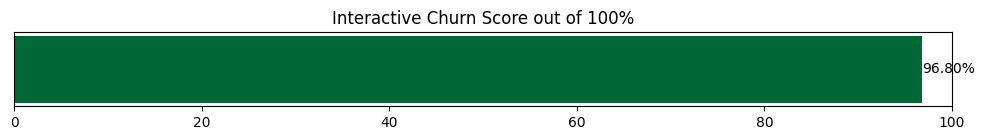

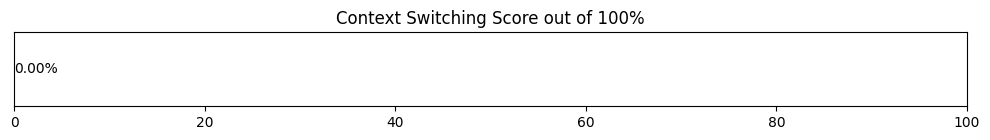

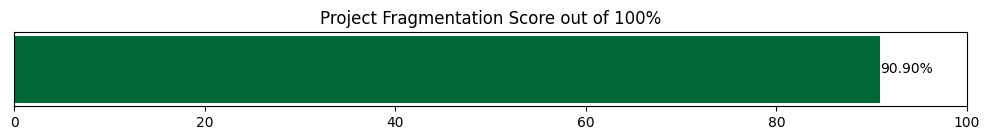

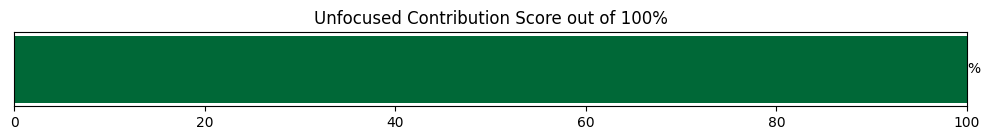

In [2]:
# WORKS
Reagent().boe_visualizations().create_percent_chart(repo)

In [3]:
# WORKS
Reagent().composite_scores().nonadversarial_components(repo).df()

,interactive_churn_score,context_switching_score,project_fragmentation_score,unfocused_contribution_score
0,96.8,0,90.9,100.0


## Non-Adversarial Totals

In [4]:
# WORKS
Reagent().composite_scores().nonadversarial_total(repo).df()

,metadata_risk_score
0,95.915


## Non-Adversarial Timezones

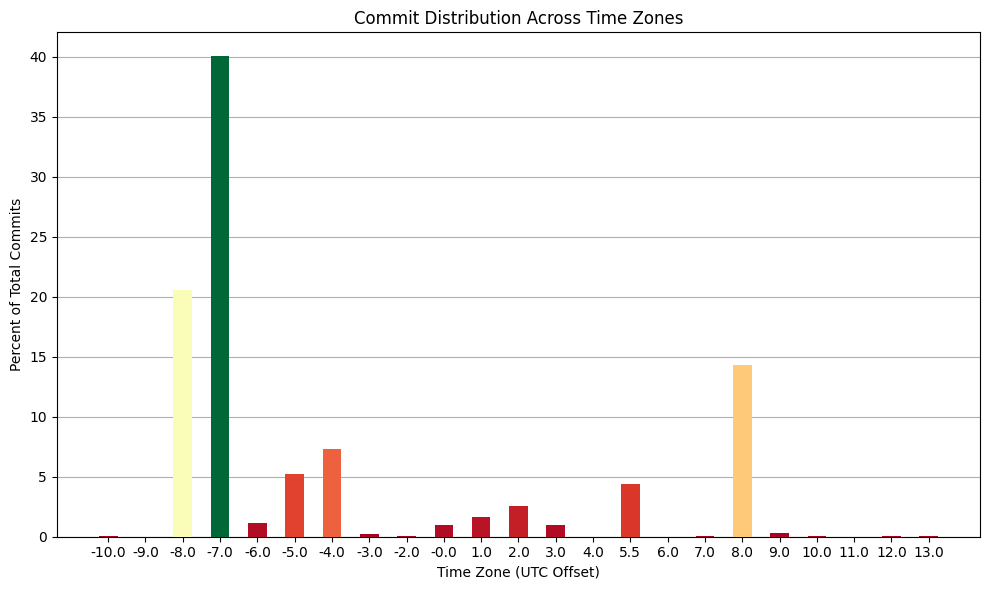

In [5]:
# WORKS
Reagent().boe_visualizations().plot_percent_timezone_color(repo)

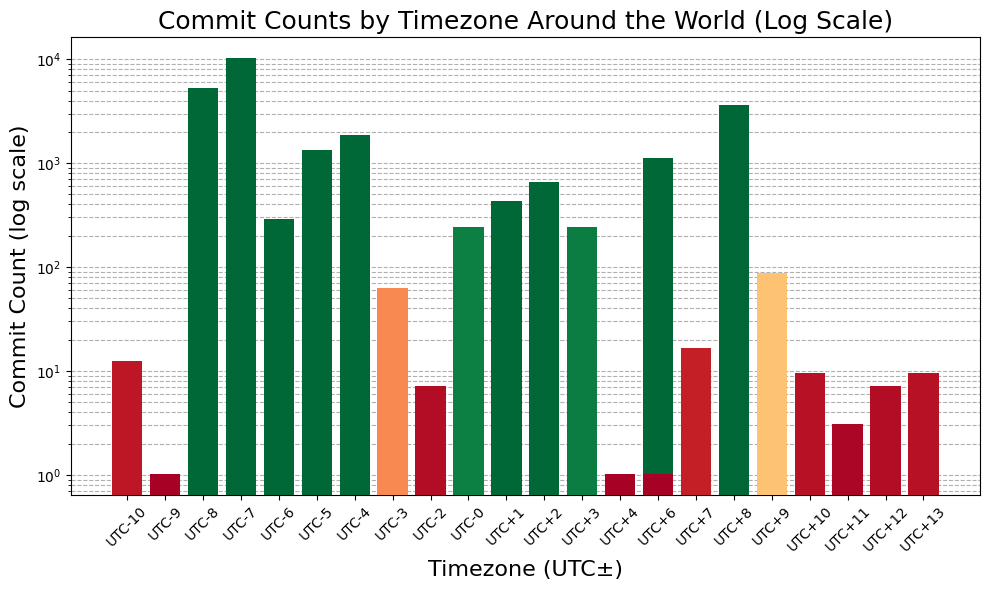

In [2]:
# WORKS
Reagent().boe_visualizations().show_percents_logarithmic_bar_chart(repo)

In [7]:
Reagent().composite_scores().nonadversarial_timezones(repo).df()

,timezone,percent_of_total_commits
0,-10.0,0.049
1,-9.0,0.004
2,-8.0,20.575
3,-7.0,40.050
4,-6.0,1.136
5,-5.0,5.235
6,-4.0,7.287
7,-3.0,0.244
8,-2.0,0.028
9,-0.0,0.953


## Adversarial Components

In [8]:
Reagent().composite_scores().adversarial_components(repo).df()

,timezone_spoofs_score,adversarial_timezones_score,purpose_built_accounts_score
0,99.5,84.7,63.4


## Adversarial Timezones

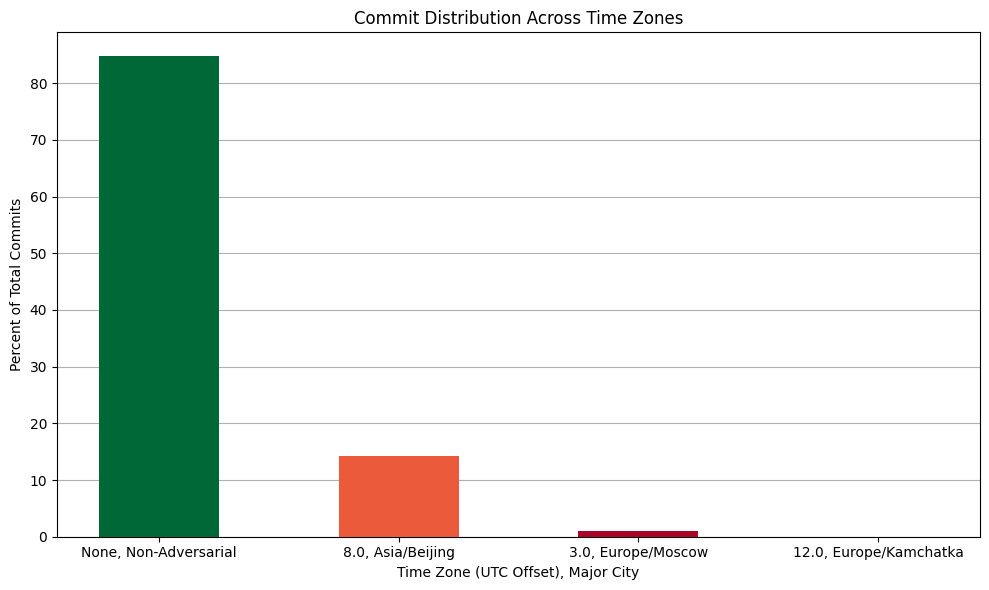

In [9]:
Reagent().boe_visualizations().plot_adversarial_percent_timezone_color(repo)

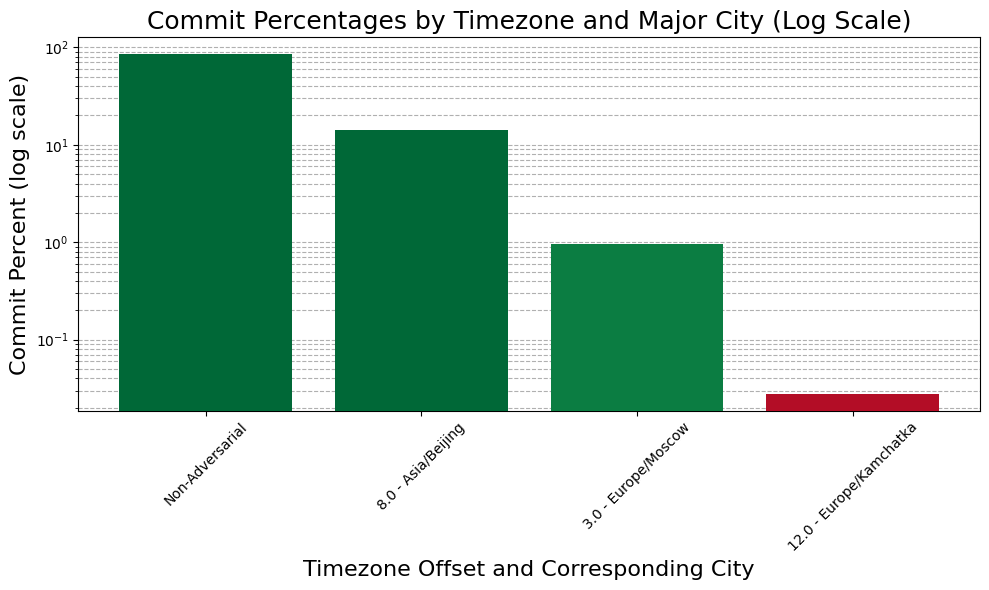

In [3]:
Reagent().boe_visualizations().show_adversarial_percents_logarithmic_bar_chart(repo)

In [11]:
Reagent().composite_scores().adversarial_timezones(repo).df()

,timezone,major_city,percent_of_total_commits
0,NaN,Non-Adversarial,84.726
1,8.0,Asia/Beijing,14.289
2,3.0,Europe/Moscow,0.957
3,12.0,Europe/Kamchatka,0.028


## Adversarial Totals

In [12]:
# WORKS
Reagent().composite_scores().adversarial_total(repo).df()

,foreign_adversarial_score
0,97.1
